In [1]:
"""
📊 SCRIPT PARA SOBREMUESTREO MEJORADO DE CLASES MINORITARIAS
==============================================================
Genera ~2000 imágenes para disgust, fear, sad con mayor variabilidad
"""

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
import warnings
warnings.filterwarnings('ignore')

print("📊 INICIANDO SOBREMUESTREO MEJORADO...")
print("=" * 80)

# Configuración
PARAMS = {
    'data_path': r'C:\Users\maria\OneDrive\Documentos\AnotherSigma\PONTIA\PROYECTO JUPITER\archive\train',
    'target_count': 2000,  # Imágenes objetivo por clase
    'classes': ['disgust', 'fear', 'sad'],
    'random_state': 42
}

# Configurar generador de aumentación con más variabilidad
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=[0.7, 1.3],
    shear_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.6, 1.4],
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

# Función para sobremuestrear una clase
def oversample_class(class_name, class_path, target_count):
    print(f"\n🔄 Procesando {class_name}...")
    try:
        images = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        current_count = len(images)
        print(f"📸 Imágenes actuales: {current_count}")
        
        if current_count >= target_count:
            print(f"✅ {class_name} ya tiene suficientes imágenes")
            return
        
        # Calcular cuántas imágenes faltan
        images_needed = target_count - current_count
        print(f"➕ Necesita {images_needed} imágenes adicionales")
        
        # Generar imágenes aumentadas
        for i, img_name in enumerate(images):
            if images_needed <= 0:
                break
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=(48, 48), color_mode='rgb')
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            
            # Generar hasta 10 imágenes por original
            aug_iter = datagen.flow(x, batch_size=1, save_to_dir=class_path, 
                                  save_prefix=f'aug_{class_name}_{i}', save_format='jpg')
            for _ in range(min(images_needed, 10)):
                aug_iter.next()
                images_needed -= 1
        
        # Duplicar imágenes si aún faltan
        if images_needed > 0:
            print(f"🔄 Duplicando imágenes para {class_name}...")
            for i, img_name in enumerate(images):
                if images_needed <= 0:
                    break
                img_path = os.path.join(class_path, img_name)
                img = load_img(img_path)
                for j in range(min(images_needed, 3)):  # Máximo 3 copias por imagen
                    save_img(os.path.join(class_path, f'copy_{i}_{j}_{img_name}'), img)
                    images_needed -= 1
        
        new_count = len([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
        print(f"✅ {class_name} ahora tiene {new_count} imágenes")
    except Exception as e:
        print(f"❌ Error en {class_name}: {e}")

# Ejecutar sobremuestreo
try:
    for class_name in PARAMS['classes']:
        class_path = os.path.join(PARAMS['data_path'], class_name)
        if not os.path.isdir(class_path):
            print(f"❌ Directorio {class_name} no encontrado")
            continue
        oversample_class(class_name, class_path, PARAMS['target_count'])
    print("\n✅ Sobremuestreo mejorado completado!")
except Exception as e:
    print(f"❌ Error general: {e}")

print("=" * 80)

📊 INICIANDO SOBREMUESTREO MEJORADO...

🔄 Procesando disgust...
📸 Imágenes actuales: 2000
✅ disgust ya tiene suficientes imágenes

🔄 Procesando fear...
📸 Imágenes actuales: 4097
✅ fear ya tiene suficientes imágenes

🔄 Procesando sad...
📸 Imágenes actuales: 4830
✅ sad ya tiene suficientes imágenes

✅ Sobremuestreo mejorado completado!


In [2]:
"""
🎖️ ENSEMBLE CON CNN Y MOBILENETV2
==============================================================
Optimizado para imágenes en escala de grises (CNN) y RGB (MobileNetV2) con sobremuestreo
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore')

print("🚀 ENSEMBLE CON CNN Y MOBILENETV2 - TARGET 80%+ ACCURACY")
print("=" * 80)

# =============================================================================
# 1. ⚙️ Configuración
# =============================================================================
print("\n🔧 CONFIGURANDO ENTORNO...")
PARAMS = {
    'data_path': r'C:\Users\maria\OneDrive\Documentos\AnotherSigma\PONTIA\PROYECTO JUPITER\archive',
    'img_size_cnn': 48,  # Para CNN (escala de grises)
    'img_size_mobilenet': 96,  # Para MobileNetV2 (mínimo soportado)
    'batch_size': 32,
    'epochs': 100,
    'learning_rate_cnn': 0.0003,
    'learning_rate_mobilenet': 0.00001,
    'random_state': 42
}

EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
NUM_CLASSES = len(EMOTIONS)

# Verificar rutas
print("\n🔄 VERIFICANDO RUTAS...")
train_path = os.path.join(PARAMS['data_path'], 'train')
test_path = os.path.join(PARAMS['data_path'], 'test')
try:
    if not os.path.isdir(train_path) or not os.path.isdir(test_path):
        print("❌ Error: Rutas no encontradas o no son directorios. Deteniendo ejecución.")
        
    print("✅ Rutas verificadas")
except Exception as e:
    print(f"❌ Error al verificar rutas: {e}. Deteniendo ejecución.")
    

# =============================================================================
# 2. 📊 Generadores de Datos
# =============================================================================
print("\n📊 CONFIGURANDO GENERADORES...")
try:
    # Generadores para CNN (escala de grises, 48x48)
    train_datagen_cnn = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.15,
        shear_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest',
        validation_split=0.2
    )

    test_datagen_cnn = ImageDataGenerator(rescale=1./255)

    train_generator_cnn = train_datagen_cnn.flow_from_directory(
        train_path,
        target_size=(PARAMS['img_size_cnn'], PARAMS['img_size_cnn']),
        color_mode='grayscale',
        batch_size=PARAMS['batch_size'],
        class_mode='sparse',
        shuffle=True,
        subset='training',
        seed=PARAMS['random_state']
    )

    validation_generator_cnn = train_datagen_cnn.flow_from_directory(
        train_path,
        target_size=(PARAMS['img_size_cnn'], PARAMS['img_size_cnn']),
        color_mode='grayscale',
        batch_size=PARAMS['batch_size'],
        class_mode='sparse',
        shuffle=True,
        subset='validation',
        seed=PARAMS['random_state']
    )

    test_generator_cnn = test_datagen_cnn.flow_from_directory(
        test_path,
        target_size=(PARAMS['img_size_cnn'], PARAMS['img_size_cnn']),
        color_mode='grayscale',
        batch_size=PARAMS['batch_size'],
        class_mode='sparse',
        shuffle=False
    )

    # Generadores para MobileNetV2 (RGB, 96x96)
    train_datagen_mobilenet = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.15,
        shear_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest',
        validation_split=0.2
    )

    test_datagen_mobilenet = ImageDataGenerator(rescale=1./255)

    train_generator_mobilenet = train_datagen_mobilenet.flow_from_directory(
        train_path,
        target_size=(PARAMS['img_size_mobilenet'], PARAMS['img_size_mobilenet']),
        color_mode='rgb',
        batch_size=PARAMS['batch_size'],
        class_mode='sparse',
        shuffle=True,
        subset='training',
        seed=PARAMS['random_state']
    )

    validation_generator_mobilenet = train_datagen_mobilenet.flow_from_directory(
        train_path,
        target_size=(PARAMS['img_size_mobilenet'], PARAMS['img_size_mobilenet']),
        color_mode='rgb',
        batch_size=PARAMS['batch_size'],
        class_mode='sparse',
        shuffle=True,
        subset='validation',
        seed=PARAMS['random_state']
    )

    test_generator_mobilenet = test_datagen_mobilenet.flow_from_directory(
       どれtest_path,
        target_size=(PARAMS['img_size_mobilenet'], PARAMS['img_size_mobilenet']),
        color_mode='rgb',
        batch_size=PARAMS['batch_size'],
        class_mode='sparse',
        shuffle=False
    )

    print(f"✅ Entrenamiento CNN: {train_generator_cnn.samples} imágenes")
    print(f"✅ Validación CNN: {validation_generator_cnn.samples} imágenes")
    print(f"✅ Prueba CNN: {test_generator_cnn.samples} imágenes")
    print(f"✅ Entrenamiento MobileNetV2: {train_generator_mobilenet.samples} imágenes")
    print(f"✅ Validación MobileNetV2: {validation_generator_mobilenet.samples} imágenes")
    print(f"✅ Prueba MobileNetV2: {test_generator_mobilenet.samples} imágenes")
except Exception as e:
    print(f"❌ Error en generadores: {e}. Deteniendo ejecución.")
    

# Obtener etiquetas de clases
class_labels = list(train_generator_cnn.class_indices.keys())

# Calcular pesos de clase
print("\n⚖️ CALCULANDO PESOS POR CLASE...")
try:
    class_weights = compute_class_weight('balanced', classes=np.unique(train_generator_cnn.classes), y=train_generator_cnn.classes)
    class_weights_dict = dict(enumerate(class_weights))
    print("📊 Pesos por clase:", {EMOTIONS[i]: f"{w:.3f}" for i, w in class_weights_dict.items()})
except Exception as e:
    print(f"❌ Error al calcular pesos: {e}. Deteniendo ejecución.")
    class_weights_dict = None
    

# =============================================================================
# 3. 🏗️ Construcción del Modelo CNN
# =============================================================================
print("\n🏗️ CONSTRUYENDO CNN...")
try:
    cnn_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(PARAMS['img_size_cnn'], PARAMS['img_size_cnn'], 1), kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    print("✅ Modelo CNN creado")
    cnn_model.summary()
except Exception as e:
    print(f"❌ Error al crear CNN: {e}. Deteniendo ejecución.")
    

# Compilación del modelo CNN
print("\n🔧 COMPILANDO CNN...")
try:
    cnn_model.compile(
        optimizer=Adam(learning_rate=PARAMS['learning_rate_cnn']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    print("✅ CNN compilado")
except Exception as e:
    print(f"❌ Error al compilar CNN: {e}. Deteniendo ejecución.")
    

🚀 ENSEMBLE CON CNN Y MOBILENETV2 - TARGET 80%+ ACCURACY

🔧 CONFIGURANDO ENTORNO...

🔄 VERIFICANDO RUTAS...
✅ Rutas verificadas

📊 CONFIGURANDO GENERADORES...
Found 24219 images belonging to 7 classes.
Found 6054 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 24219 images belonging to 7 classes.
Found 6054 images belonging to 7 classes.
❌ Error en generadores: name 'どれtest_path' is not defined. Deteniendo ejecución.

⚖️ CALCULANDO PESOS POR CLASE...
📊 Pesos por clase: {'angry': '1.083', 'disgust': '2.162', 'fear': '1.055', 'happy': '0.599', 'neutral': '0.871', 'sad': '0.895', 'surprise': '1.364'}

🏗️ CONSTRUYENDO CNN...
✅ Modelo CNN creado
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 

In [3]:
# =============================================================================
# 4. 🚀 Entrenamiento del Modelo CNN
# =============================================================================
print("\n🚀 INICIANDO ENTRENAMIENTO DE CNN...")
try:
    callbacks_cnn = [
        EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
    ]
    history_cnn = cnn_model.fit(
        train_generator_cnn,
        steps_per_epoch=max(1, train_generator_cnn.samples // PARAMS['batch_size']),
        epochs=PARAMS['epochs'],
        validation_data=validation_generator_cnn,
        validation_steps=max(1, validation_generator_cnn.samples // PARAMS['batch_size']),
        class_weight=class_weights_dict,
        callbacks=callbacks_cnn,
        verbose=1
    )
    print("\n✅ Entrenamiento de CNN completado!")
except Exception as e:
    print(f"❌ Error en entrenamiento de CNN: {e}")
    exit()

# Guardar modelo CNN
try:
    cnn_model.save('emotion_cnn.h5')
    print("\n💾 Modelo CNN guardado")
except Exception as e:
    print(f"❌ Error al guardar CNN: {e}")


🚀 INICIANDO ENTRENAMIENTO DE CNN...
Epoch 1/100
756/756 [==============================] - 120s 156ms/step - loss: 18.2588 - accuracy: 0.2059 - val_loss: 13.1792 - val_accuracy: 0.2812 - lr: 3.0000e-04
Epoch 2/100
756/756 [==============================] - 108s 142ms/step - loss: 9.8905 - accuracy: 0.2974 - val_loss: 6.9192 - val_accuracy: 0.3274 - lr: 3.0000e-04
Epoch 3/100
756/756 [==============================] - 116s 154ms/step - loss: 5.3126 - accuracy: 0.3518 - val_loss: 4.1243 - val_accuracy: 0.3945 - lr: 3.0000e-04
Epoch 4/100
756/756 [==============================] - 120s 159ms/step - loss: 3.4838 - accuracy: 0.3931 - val_loss: 3.0310 - val_accuracy: 0.4135 - lr: 3.0000e-04
Epoch 5/100
756/756 [==============================] - 121s 160ms/step - loss: 2.6016 - accuracy: 0.4406 - val_loss: 2.4999 - val_accuracy: 0.4277 - lr: 3.0000e-04
Epoch 6/100
756/756 [==============================] - 122s 161ms/step - loss: 2.2307 - accuracy: 0.4629 - val_loss: 2.3865 - val_accuracy: 0

In [4]:
# =============================================================================
# 5. 🏗️ Construcción del Modelo MobileNetV2
# =============================================================================
print("\n🏗️ CONSTRUYENDO MOBILENETV2...")
try:
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(PARAMS['img_size_mobilenet'], PARAMS['img_size_mobilenet'], 3))
    for layer in base_model.layers[:-100]:
        layer.trainable = False
    for layer in base_model.layers[-100:]:
        layer.trainable = True

    mobilenet_model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    print("✅ Modelo MobileNetV2 creado")
    mobilenet_model.summary()
except Exception as e:
    print(f"❌ Error al crear MobileNetV2: {e}")

# Compilación del modelo MobileNetV2
print("\n🔧 COMPILANDO MOBILENETV2...")
try:
    mobilenet_model.compile(
        optimizer=Adam(learning_rate=PARAMS['learning_rate_mobilenet']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    print("✅ MobileNetV2 compilado")
except Exception as e:
    print(f"❌ Error al compilar MobileNetV2: {e}")


🏗️ CONSTRUYENDO MOBILENETV2...
✅ Modelo MobileNetV2 creado
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 7)                 1799      
                                                            

In [5]:
# =============================================================================
# 6. 🚀 Entrenamiento del Modelo MobileNetV2
# =============================================================================
print("\n🚀 INICIANDO ENTRENAMIENTO DE MOBILENETV2...")
try:
    callbacks_mobilenet = [
        EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
    ]
    history_mobilenet = mobilenet_model.fit(
        train_generator_mobilenet,
        steps_per_epoch=max(1, train_generator_mobilenet.samples // PARAMS['batch_size']),
        epochs=PARAMS['epochs'],
        validation_data=validation_generator_mobilenet,
        validation_steps=max(1, validation_generator_mobilenet.samples // PARAMS['batch_size']),
        class_weight=class_weights_dict,
        callbacks=callbacks_mobilenet,
        verbose=1
    )
    print("\n✅ Entrenamiento de MobileNetV2 completado!")
except Exception as e:
    print(f"❌ Error en entrenamiento de MobileNetV2: {e}")
    exit()

# Guardar modelo MobileNetV2
try:
    mobilenet_model.save('emotion_mobilenetv2_ensemble.h5')
    print("\n💾 Modelo MobileNetV2 guardado")
except Exception as e:
    print(f"❌ Error al guardar MobileNetV2: {e}")


🚀 INICIANDO ENTRENAMIENTO DE MOBILENETV2...
Epoch 1/100
756/756 [==============================] - 257s 330ms/step - loss: 6.2998 - accuracy: 0.2104 - val_loss: 6.2273 - val_accuracy: 0.1997 - lr: 1.0000e-05
Epoch 2/100
756/756 [==============================] - 242s 321ms/step - loss: 5.7787 - accuracy: 0.3105 - val_loss: 5.8228 - val_accuracy: 0.3018 - lr: 1.0000e-05
Epoch 3/100
756/756 [==============================] - 233s 308ms/step - loss: 5.4773 - accuracy: 0.3642 - val_loss: 5.5134 - val_accuracy: 0.3669 - lr: 1.0000e-05
Epoch 4/100
756/756 [==============================] - 224s 296ms/step - loss: 5.2220 - accuracy: 0.4071 - val_loss: 5.2904 - val_accuracy: 0.4119 - lr: 1.0000e-05
Epoch 5/100
756/756 [==============================] - 237s 313ms/step - loss: 5.0020 - accuracy: 0.4352 - val_loss: 5.0861 - val_accuracy: 0.4261 - lr: 1.0000e-05
Epoch 6/100
756/756 [==============================] - 259s 342ms/step - loss: 4.7822 - accuracy: 0.4576 - val_loss: 4.8816 - val_accur

In [8]:
# =============================================================================
# 7. 🧪 Evaluación Individual de Modelos
# =============================================================================
print("\n🧪 EVALUANDO MODELOS INDIVIDUALMENTE...")
try:
    # Configurar generadores de prueba
    test_path = os.path.join(PARAMS['data_path'], 'test')
    test_datagen_cnn = ImageDataGenerator(rescale=1./255)
    test_generator_cnn = test_datagen_cnn.flow_from_directory(
        test_path,
        target_size=(PARAMS['img_size_cnn'], PARAMS['img_size_cnn']),
        color_mode='grayscale',
        batch_size=PARAMS['batch_size'],
        class_mode='sparse',
        shuffle=False
    )

    test_datagen_mobilenet = ImageDataGenerator(rescale=1./255)
    test_generator_mobilenet = test_datagen_cnn.flow_from_directory(
        test_path,
        target_size=(PARAMS['img_size_mobilenet'], PARAMS['img_size_mobilenet']),
        color_mode='rgb',
        batch_size=PARAMS['batch_size'],
        class_mode='sparse',
        shuffle=False
    )

    print(f"✅ Prueba CNN: {test_generator_cnn.samples} imágenes")
    print(f"✅ Prueba MobileNetV2: {test_generator_mobilenet.samples} imágenes")

    # Evaluación CNN
    test_generator_cnn.reset()
    test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(
        test_generator_cnn, 
        steps=test_generator_cnn.samples // PARAMS['batch_size'] + 1,
        verbose=1
    )
    print(f"\n📊 CNN - Test Accuracy: {test_accuracy_cnn:.4f}, Test Loss: {test_loss_cnn:.4f}")
    
    # Evaluación MobileNetV2
    test_generator_mobilenet.reset()
    test_loss_mobilenet, test_accuracy_mobilenet = mobilenet_model.evaluate(
        test_generator_mobilenet, 
        steps=test_generator_mobilenet.samples // PARAMS['batch_size'] + 1,
        verbose=1
    )
    print(f"\n📊 MobileNetV2 - Test Accuracy: {test_accuracy_mobilenet:.4f}, Test Loss: {test_loss_mobilenet:.4f}")
except Exception as e:
    print(f"❌ Error en evaluación individual: {e}. Deteniendo ejecución.")
    


🧪 EVALUANDO MODELOS INDIVIDUALMENTE...
Found 7178 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
✅ Prueba CNN: 7178 imágenes
✅ Prueba MobileNetV2: 7178 imágenes
225/225 [==============================] - 10s 46ms/step - loss: 1.3290 - accuracy: 0.6172

📊 CNN - Test Accuracy: 0.6172, Test Loss: 1.3290
225/225 [==============================] - 21s 94ms/step - loss: 1.7431 - accuracy: 0.5816

📊 MobileNetV2 - Test Accuracy: 0.5816, Test Loss: 1.7431


In [9]:
# =============================================================================
# 8. 🤝 Ensemble: Promedio de Predicciones Softmax
# =============================================================================
print("\n🤝 GENERANDO PREDICCIONES DEL ENSEMBLE...")
try:
    test_generator_cnn.reset()
    test_generator_mobilenet.reset()
    # Predicciones de CNN
    y_pred_cnn = cnn_model.predict(
        test_generator_cnn, steps=max(1, test_generator_cnn.samples // PARAMS['batch_size'] + 1)
    )
    # Predicciones de MobileNetV2
    y_pred_mobilenet = mobilenet_model.predict(
        test_generator_mobilenet, steps=max(1, test_generator_mobilenet.samples // PARAMS['batch_size'] + 1)
    )
    # Promedio de predicciones softmax
    y_pred_ensemble = (y_pred_cnn + y_pred_mobilenet) / 2
    y_pred_classes = np.argmax(y_pred_ensemble, axis=1)
    y_true = test_generator_cnn.classes[:len(y_pred_classes)]
    print("✅ Predicciones del ensemble generadas")
except Exception as e:
    print(f"❌ Error en predicciones del ensemble: {e}")
    exit()

# Calcular precisión del ensemble
ensemble_accuracy = np.mean(y_pred_classes == y_true)
print(f"\n📊 Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"🎯 Target 80%: {'✅ ALCANZADO' if ensemble_accuracy >= 0.8 else '❌ NO ALCANZADO'}")


🤝 GENERANDO PREDICCIONES DEL ENSEMBLE...
225/225 [==============================] - 23s 96ms/step
✅ Predicciones del ensemble generadas

📊 Ensemble Accuracy: 0.6397
🎯 Target 80%: ❌ NO ALCANZADO



📈 GRÁFICAS DE ENTRENAMIENTO...


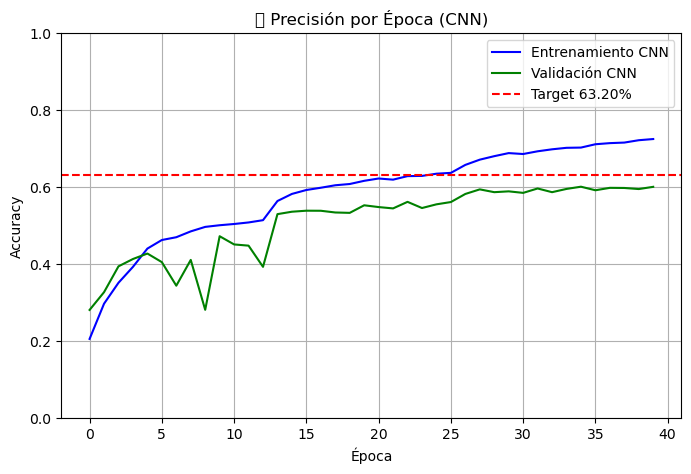

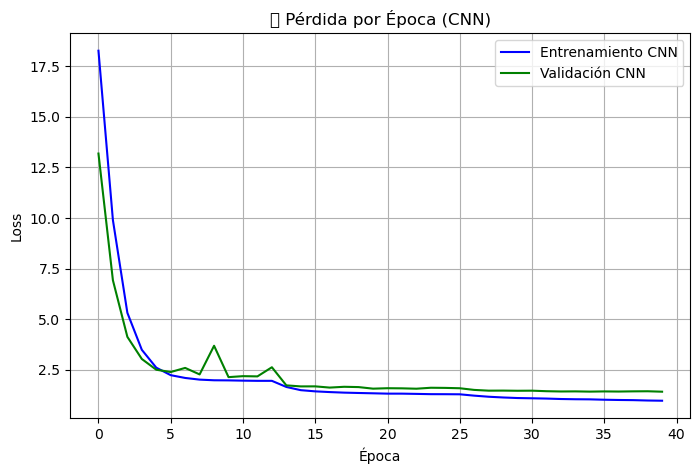

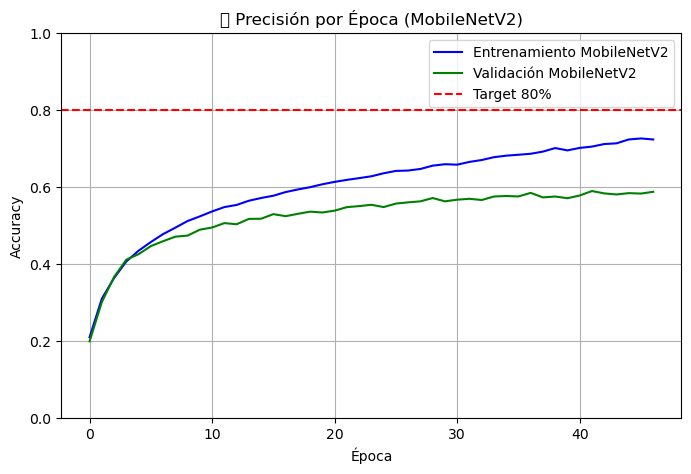

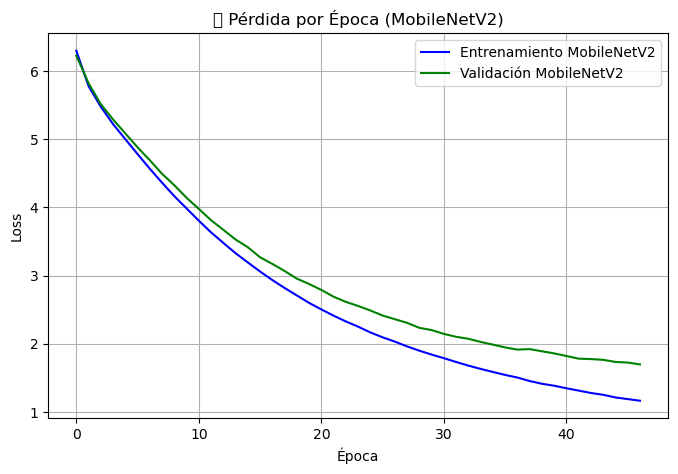


🎭 MATRIZ DE CONFUSIÓN (ENSEMBLE)...


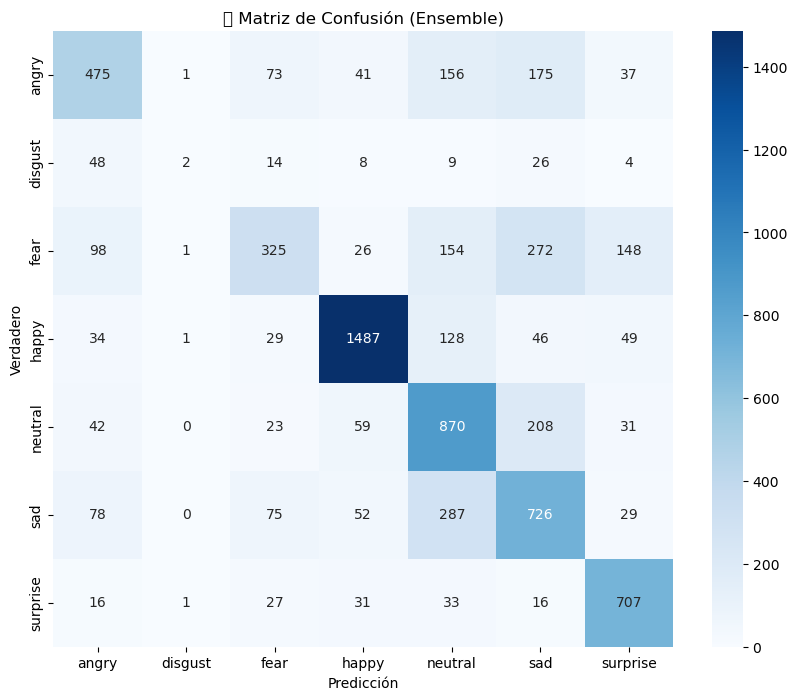


📋 REPORTE DETALLADO (ENSEMBLE)...
              precision    recall  f1-score   support

       angry     0.6005    0.4958    0.5432       958
     disgust     0.3333    0.0180    0.0342       111
        fear     0.5742    0.3174    0.4088      1024
       happy     0.8727    0.8382    0.8551      1774
     neutral     0.5315    0.7056    0.6063      1233
         sad     0.4942    0.5822    0.5346      1247
    surprise     0.7035    0.8508    0.7702       831

    accuracy                         0.6397      7178
   macro avg     0.5871    0.5440    0.5360      7178
weighted avg     0.6415    0.6397    0.6288      7178


📊 Weighted F1-Score: 0.6288

📊 GRÁFICA DE PRECISIÓN POR CLASE (ENSEMBLE)...


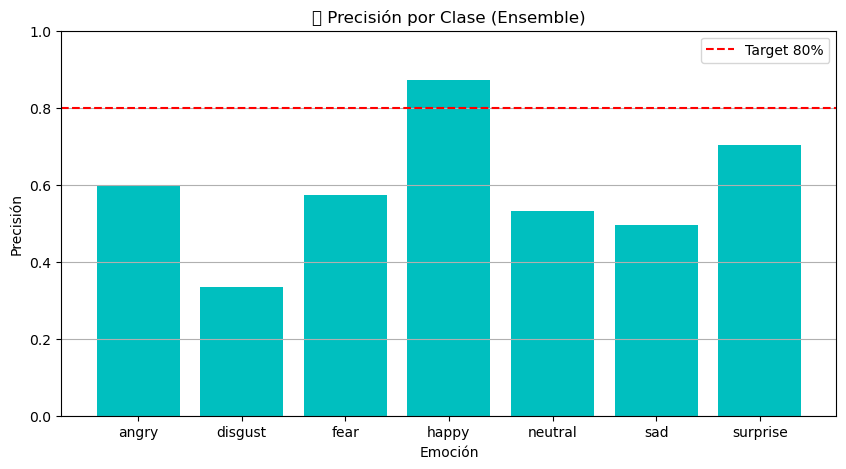


🎯 ANÁLISIS POR CLASE (ENSEMBLE)...

angry:
  Verdaderos positivos: 475
  Falsos positivos: 316
  Falsos negativos: 483
  Se confunde con:
    - disgust: 1 veces
    - fear: 73 veces
    - happy: 41 veces
    - neutral: 156 veces
    - sad: 175 veces
    - surprise: 37 veces

disgust:
  Verdaderos positivos: 2
  Falsos positivos: 4
  Falsos negativos: 109
  Se confunde con:
    - angry: 48 veces
    - fear: 14 veces
    - happy: 8 veces
    - neutral: 9 veces
    - sad: 26 veces
    - surprise: 4 veces

fear:
  Verdaderos positivos: 325
  Falsos positivos: 241
  Falsos negativos: 699
  Se confunde con:
    - angry: 98 veces
    - disgust: 1 veces
    - happy: 26 veces
    - neutral: 154 veces
    - sad: 272 veces
    - surprise: 148 veces

happy:
  Verdaderos positivos: 1487
  Falsos positivos: 217
  Falsos negativos: 287
  Se confunde con:
    - angry: 34 veces
    - disgust: 1 veces
    - fear: 29 veces
    - neutral: 128 veces
    - sad: 46 veces
    - surprise: 49 veces

neutral:
 

In [10]:
# =============================================================================
# 9. 📈 Gráficas de Entrenamiento
# =============================================================================
print("\n📈 GRÁFICAS DE ENTRENAMIENTO...")
if 'history_cnn' in locals():
    # Gráfica de Precisión (CNN)
    plt.figure(figsize=(8, 5))
    plt.plot(history_cnn.history['accuracy'], label='Entrenamiento CNN', color='b')
    plt.plot(history_cnn.history['val_accuracy'], label='Validación CNN', color='g')
    plt.axhline(y=0.6320, color='r', linestyle='--', label='Target 63.20%')
    plt.title('🎯 Precisión por Época (CNN)')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.savefig('cnn_accuracy_plot.png', dpi=300)
    plt.show()

    # Gráfica de Pérdida (CNN)
    plt.figure(figsize=(8, 5))
    plt.plot(history_cnn.history['loss'], label='Entrenamiento CNN', color='b')
    plt.plot(history_cnn.history['val_loss'], label='Validación CNN', color='g')
    plt.title('📉 Pérdida por Época (CNN)')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.savefig('cnn_loss_plot.png', dpi=300)
    plt.show()

if 'history_mobilenet' in locals():
    # Gráfica de Precisión (MobileNetV2)
    plt.figure(figsize=(8, 5))
    plt.plot(history_mobilenet.history['accuracy'], label='Entrenamiento MobileNetV2', color='b')
    plt.plot(history_mobilenet.history['val_accuracy'], label='Validación MobileNetV2', color='g')
    plt.axhline(y=0.8, color='r', linestyle='--', label='Target 80%')
    plt.title('🎯 Precisión por Época (MobileNetV2)')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.savefig('mobilenetv2_ensemble_accuracy_plot.png', dpi=300)
    plt.show()

    # Gráfica de Pérdida (MobileNetV2)
    plt.figure(figsize=(8, 5))
    plt.plot(history_mobilenet.history['loss'], label='Entrenamiento MobileNetV2', color='b')
    plt.plot(history_mobilenet.history['val_loss'], label='Validación MobileNetV2', color='g')
    plt.title('📉 Pérdida por Época (MobileNetV2)')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.savefig('mobilenetv2_ensemble_loss_plot.png', dpi=300)
    plt.show()

# =============================================================================
# 10. 🎭 Matriz de Confusión (Ensemble)
# =============================================================================
print("\n🎭 MATRIZ DE CONFUSIÓN (ENSEMBLE)...")
try:
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('🎭 Matriz de Confusión (Ensemble)')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.savefig('ensemble_confusion_matrix.png', dpi=300)
    plt.show()
except Exception as e:
    print(f"❌ Error en matriz de confusión: {e}")

# =============================================================================
# 11. 📋 Reporte Detallado (Ensemble)
# =============================================================================
print("\n📋 REPORTE DETALLADO (ENSEMBLE)...")
try:
    print(classification_report(y_true, y_pred_classes, target_names=class_labels, digits=4))
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    print(f"\n📊 Weighted F1-Score: {f1:.4f}")
except Exception as e:
    print(f"❌ Error en reporte: {e}")

# Gráfica de Precisión por Clase (Ensemble)
print("\n📊 GRÁFICA DE PRECISIÓN POR CLASE (ENSEMBLE)...")
try:
    report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)
    class_accuracies = [report[emotion]['precision'] for emotion in class_labels]
    
    plt.figure(figsize=(10, 5))
    plt.bar(class_labels, class_accuracies, color='c')
    plt.axhline(y=0.8, color='r', linestyle='--', label='Target 80%')
    plt.title('🎯 Precisión por Clase (Ensemble)')
    plt.xlabel('Emoción')
    plt.ylabel('Precisión')
    plt.ylim(0, 1)
    plt.grid(True, axis='y')
    plt.legend()
    plt.savefig('ensemble_class_accuracy_plot.png', dpi=300)
    plt.show()
except Exception as e:
    print(f"❌ Error en gráfica por clase: {e}")

# Análisis de la Matriz de Confusión (Ensemble)
print("\n🎯 ANÁLISIS POR CLASE (ENSEMBLE)...")
try:
    for i, emotion in enumerate(class_labels):
        true_positives = cm[i, i]
        false_positives = sum(cm[:, i]) - true_positives
        false_negatives = sum(cm[i, :]) - true_positives
        print(f"\n{emotion}:")
        print(f"  Verdaderos positivos: {true_positives}")
        print(f"  Falsos positivos: {false_positives}")
        print(f"  Falsos negativos: {false_negatives}")
        confusions = [(label, cm[i, j]) for j, label in enumerate(class_labels) if j != i and cm[i, j] > 0]
        if confusions:
            print("  Se confunde con:")
            for conf_emotion, count in confusions:
                print(f"    - {conf_emotion}: {count} veces")
except Exception as e:
    print(f"❌ Error en análisis de confusión: {e}")

In [ ]:
# =============================================================================
# 12. 💾 Resumen Final
# =============================================================================
print("\n" + "="*80)
print("📊 RESUMEN FINAL:")
print(f"CNN Test Accuracy: {test_accuracy_cnn:.4f}")
print(f"MobileNetV2 Test Accuracy: {test_accuracy_mobilenet:.4f}")
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")
print(f"🎯 Target 80%: {'✅ ALCANZADO' if ensemble_accuracy >= 0.8 else '❌ NO ALCANZADO'}")
print("🔧 Próximos pasos si no se alcanzó 80%:")
print("   • Fine-tuning escalonado con sobremuestreo refinado (~2500 imágenes)")
print("   • Escala de grises con MobileNetV2 sin pesos preentrenados")
print("   • Aumentar batch_size a 64 y épocas a 50")
print("="*80)